In [11]:
from __future__ import print_function
#%matplotlib inline
import os, time, sys
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [104]:
##### define transform #####

# toTensor() converts PIL images / np.ndarray to tensor 
# (H * W * C) to (C * H * W) |  [0, 255] to [0.0, 1.0]

# Normalize() transforms pixel intensities from [0, 1] to [-1, 1]

transform = transforms.Compose(
    [transforms.Scale(64),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])])

# processing 4 images at once. *adjustable*
batch_size = 128

# set trainset: loading CIFAR-10, apply previously defined transform function
trainset = torchvision.datasets.CIFAR10(root = './data', 
                                        train = True, 
                                        download = True, 
                                        transform = transform)

# set trainloader: put training dataset to DataLoader
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


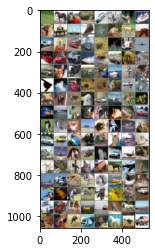

deer  horse horse deer  automobile deer  bird  ship  cat   airplane ship  bird  deer  cat   dog   horse truck dog   truck ship  frog  deer  truck airplane automobile automobile truck ship  deer  automobile dog   dog   automobile dog   cat   airplane bird  ship  airplane cat   airplane dog   automobile deer  frog  dog   airplane dog   frog  horse dog   bird  automobile airplane frog  frog  truck ship  cat   cat   deer  cat   frog  automobile dog   bird  dog   airplane cat   horse airplane cat   automobile ship  automobile airplane truck cat   airplane ship  deer  airplane cat   truck dog   automobile airplane truck deer  frog  bird  cat   truck horse airplane bird  ship  truck cat   bird  cat   ship  cat   cat   bird  frog  horse bird  dog   frog  frog  automobile automobile truck dog   airplane ship  dog   horse ship  frog  frog  bird  truck frog  horse airplane automobile


In [105]:
# this is pytorch code on image display

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [120]:
# generator
# latent vector (random noise) -> CIFAR-10 like image
class Generator(nn.Module):
    def __init__(self, input_size = 128):
        super(Generator, self).__init__()
        
        # 100 -> 1024 * 4 * 4
        self.convT1 = nn.ConvTranspose2d(100, input_size*8, 4, stride = 1, padding = 0)
        self.bn1 = nn.BatchNorm2d(input_size*8)
        
        # 1024 * 4* 4 -> 512 * 8 * 8
        self.convT2 = nn.ConvTranspose2d(input_size*8, input_size*4, 4, stride = 2, padding = 1)
        self.bn2 = nn.BatchNorm2d(input_size*4)
        
        # 512 * 8 * 8 -> 256 * 16 * 16
        self.convT3 = nn.ConvTranspose2d(input_size*4, input_size*2, 4, stride = 2, padding = 1)
        self.bn3 = nn.BatchNorm2d(input_size*2)
        
        #258 * 16 * 16 -> 128 * 32 * 32
        self.convT4 = nn.ConvTranspose2d(input_size*2, input_size, 4, stride = 2, padding = 1)
        self.bn4 = nn.BatchNorm2d(input_size)
        
        # 128 * 32 * 32 -> 3 * 64 * 64
        self.convT5 = nn.ConvTranspose2d(input_size, 3, 4, stride = 2, padding = 1)
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, input):
        x = F.relu(self.bn1(self.convT1(input)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))
        x = F.tanh(self.convT5(x))
        
        return x

In [121]:
# discriminator
# image -> scalar probability of absurdity (probability of image being real)
class Discriminator(nn.Module):
    def __init__(self, ndf = 128):
        super(Discriminator, self).__init__()
        
        # input is 3 x 64 x 64
        # 3 * 64 * 64 -> 128 * 32 * 32
        self.conv1 = nn.Conv2d(3, ndf, 4, stride = 2, padding = 1)
        #self.bn1 = nn.BatchNorm2d(ndf)
        
        # 128 * 32 * 32 -> 256 * 16 * 16
        self.conv2 = nn.Conv2d(ndf, ndf*2, 4, stride = 2, padding = 1)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
        
        # 256 * 16 * 16 -> 512 * 8 * 8
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, 4, stride = 2, padding = 1)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        
        # 512 * 8 * 8 -> 1024 * 4 * 4
        self.conv4 = nn.Conv2d(ndf*4, ndf*8, 4, stride = 2, padding = 1)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        
        # 1024 * 4 * 4 -> 1
        self.conv5 = nn.Conv2d(ndf*8, 1, 4, stride = 1, padding = 0)


    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))
        
        return x

In [122]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean,std)
        m.bias.data.zero_()

In [123]:
# avoid backpropagation to conserve memory
with torch.no_grad():
    #fixed noise
    fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1).cuda()

In [137]:
def show_results(num_epoch, show = False, save = False, path = 'result.png', isFix = False):
    z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1).cuda()
    
    G.eval()
    if isFix:
        test_images = G(fixed_z_)
    else:
        test_images = G(z_)
    G.train()
    
    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize = (5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
    
    for k in range(5 * 5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow((test_images[k].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
    
    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha = 'center')
    plt.savefig(path)
    
    if show:
        plt.show()
    else:
        plt.close()

In [125]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
        x = range(len(hist['D_losses']))

        y1 = hist['D_losses']
        y2 = hist['G_losses']

        plt.plot(x, y1, label='D_loss')
        plt.plot(x, y2, label='G_loss')

        plt.xlabel('Iter')
        plt.ylabel('Loss')

        plt.legend(loc=4)
        plt.grid(True)
        plt.tight_layout()

        if save:
            plt.savefig(path)

        if show:
            plt.show()
        else:
            plt.close()

In [126]:
device = torch.device('cuda')

In [127]:
# Root directory for dataset
data_dir = "./data"

# Number of workers for dataloader
workers = 2

batch_size = 128

# learning rate = 0.0002 according to paper
lr = 0.0002

img_size = 64

isCrop = False

train_epoch = 20

In [128]:
if isCrop:
    transform = transforms.Compose([
        transforms.Scale(108),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [129]:
temp = trainset[0][0].permute(1, 2, 0).numpy()
if (temp.shape[0] != img_size) or (temp.shape[0] != img_size):
    sys.stderr.write('Error! image size is not 64 x 64! !!!')
    sys.exit(1)

In [130]:
G = Generator(128)
D = Discriminator(128)

# weight setting according to paper
G.weight_init(mean = 0.0, std = 0.02)
D.weight_init(mean = 0.0, std = 0.02)

# all to GPU :P
G.cuda()
D.cuda()

Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [131]:
criterion = nn.BCELoss()

# adam, tuning specific to paper
G_optimizer = optim.Adam(G.parameters(), lr = lr, betas = (0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr = lr, betas = (0.5, 0.999))

In [132]:
# results save folder
if not os.path.isdir('CIFAR10_DCGAN_results'):
    os.mkdir('CIFAR10_DCGAN_results')
if not os.path.isdir('CIFAR10_DCGAN_results/Random_results'):
    os.mkdir('CIFAR10_DCGAN_results/Random_results')
if not os.path.isdir('CIFAR10_DCGAN_results/Fixed_results'):
    os.mkdir('CIFAR10_DCGAN_results/Fixed_results')

In [139]:
from tqdm import tqdm

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

start_time = time.time()
for epoch in tqdm(range(train_epoch)):
    D_losses = []
    G_losses = []

    # learning rate decay
    if (epoch+1) == 11:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    if (epoch+1) == 16:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    num_iter = 0

    epoch_start_time = time.time()
    for x_, _ in trainloader:
        # train discriminator D
        D.zero_grad()
        
        if isCrop:
            x_ = x_[:, :, 22:86, 22:86]

        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        x_, y_real_, y_fake_ = Variable(x_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())
        D_result = D(x_).squeeze()
        D_real_loss = criterion(D_result, y_real_)

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())
        G_result = G(z_)

        D_result = D(G_result).squeeze()
        D_fake_loss = criterion(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.item())

        # train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())

        G_result = G(z_)
        D_result = D(G_result).squeeze()
        G_train_loss = criterion(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())

        num_iter += 1

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time


    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    p = 'CIFAR10_DCGAN_results/Random_results/CIFAR10_DCGAN_' + str(epoch + 1) + '.png'
    fixed_p = 'CIFAR10_DCGAN_results/Fixed_results/CIFAR10_DCGAN_' + str(epoch + 1) + '.png'
    show_results((epoch+1), save=True, path=p, isFix=False)
    show_results((epoch+1), save=True, path=fixed_p, isFix=True)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)


  0%|          | 0/20 [00:00<?, ?it/s]

[1/20] - ptime: 153.33, loss_d: 0.000, loss_g: 63.214


  5%|▌         | 1/20 [02:36<49:26, 156.16s/it]

[2/20] - ptime: 154.03, loss_d: 0.000, loss_g: 63.189


 10%|█         | 2/20 [05:13<47:01, 156.73s/it]

[3/20] - ptime: 154.14, loss_d: 0.000, loss_g: 63.154


 15%|█▌        | 3/20 [07:50<44:26, 156.87s/it]

[4/20] - ptime: 154.07, loss_d: 0.000, loss_g: 63.123


 20%|██        | 4/20 [10:27<41:52, 157.03s/it]

[5/20] - ptime: 154.15, loss_d: 0.000, loss_g: 63.095


 25%|██▌       | 5/20 [13:04<39:16, 157.10s/it]

[6/20] - ptime: 155.20, loss_d: 0.000, loss_g: 63.072


 30%|███       | 6/20 [15:43<36:47, 157.67s/it]

[7/20] - ptime: 154.09, loss_d: 0.000, loss_g: 63.051


 35%|███▌      | 7/20 [18:20<34:07, 157.48s/it]

[8/20] - ptime: 155.34, loss_d: 0.000, loss_g: 63.023


 40%|████      | 8/20 [20:58<31:31, 157.63s/it]

[9/20] - ptime: 154.22, loss_d: 0.000, loss_g: 63.004


 45%|████▌     | 9/20 [23:36<28:54, 157.70s/it]

[10/20] - ptime: 154.12, loss_d: 0.000, loss_g: 62.990


 50%|█████     | 10/20 [26:13<26:16, 157.62s/it]

learning rate change!
[11/20] - ptime: 154.21, loss_d: 0.000, loss_g: 62.975


 55%|█████▌    | 11/20 [28:51<23:37, 157.47s/it]

[12/20] - ptime: 154.16, loss_d: 0.000, loss_g: 62.962


 60%|██████    | 12/20 [31:28<20:59, 157.47s/it]

[13/20] - ptime: 154.97, loss_d: 0.000, loss_g: 62.965


 65%|██████▌   | 13/20 [34:06<18:22, 157.56s/it]

[14/20] - ptime: 154.26, loss_d: 0.000, loss_g: 62.972


 70%|███████   | 14/20 [36:43<15:45, 157.60s/it]

[15/20] - ptime: 154.11, loss_d: 0.000, loss_g: 62.956


 75%|███████▌  | 15/20 [39:20<13:07, 157.42s/it]

learning rate change!
[16/20] - ptime: 154.08, loss_d: 0.000, loss_g: 62.955


 80%|████████  | 16/20 [41:58<10:29, 157.44s/it]

[17/20] - ptime: 154.13, loss_d: 0.000, loss_g: 62.958


 85%|████████▌ | 17/20 [44:35<07:51, 157.29s/it]

[18/20] - ptime: 155.50, loss_d: 0.000, loss_g: 62.960


 90%|█████████ | 18/20 [47:14<05:15, 157.76s/it]

[19/20] - ptime: 155.42, loss_d: 0.000, loss_g: 62.944


 95%|█████████▌| 19/20 [49:52<02:37, 157.90s/it]

[20/20] - ptime: 154.85, loss_d: 0.000, loss_g: 62.956


100%|██████████| 20/20 [52:29<00:00, 157.50s/it]
